In [1]:
# System
import os
import sys

# Maths
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score

# Atoms
from ase.io import read, write

# Plotting
import matplotlib.pyplot as plt

# SOAP density utilities
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
from soap import reshape_soaps, reshape_expansion
from soap import librascal_soap, compute_soap_density
from soap import legendre_dvr

# General utilities
from tqdm.auto import tqdm
import project_utils as utils

# Setup

In [2]:
# Load frameworks
deem_10k = read('../Raw_Data/DEEM_10k/DEEM_10000.xyz', index=':')
iza_230 = read('../Raw_Data/GULP/IZA_230/IZA_230.xyz', index=':')

In [3]:
deem_idxs = np.arange(0, len(deem_10k))
np.random.shuffle(deem_idxs)
n_deem_train = 9000
deem_train_idxs = deem_idxs[0:n_deem_train]
deem_test_idxs = deem_idxs[n_deem_train:]

iza_train_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [4]:
iza_cantons = np.ones(len(iza_230), dtype=int)
deem_cantons = np.ones(len(deem_10k), dtype=int) * 2

In [5]:
species_list = np.unique([np.unique(frame.get_atomic_numbers()) for frame in deem_10k+iza_230]).tolist()
n_species = len(species_list)

# Compute SOAPs

In [6]:
contracted_basis = True

## Basis contraction

In [7]:
# Expansion hyperparameters
basis_hyperparameters = dict(
    radial_basis='DVR',
    max_radial=32,
    max_angular=9,
    interaction_cutoff=6.0,
    gaussian_sigma_type='Constant',
    gaussian_sigma_constant=0.3,
    cutoff_smooth_width=0.3,
)

basis_args = dict(
    center_species=[14],
    representation='SphericalExpansion',
    average=False,
    concatenate=True
)

In [8]:
if contracted_basis:
    
    n_max = basis_hyperparameters['max_radial']
    l_max = basis_hyperparameters['max_angular']
    
    batch_size = 100
    n_deem = len(deem_10k)
    n_batches = n_deem // batch_size
    if n_deem % batch_size > 0:
        n_batches += 1
    
    C = np.zeros((n_species, l_max + 1, n_max, n_max))
    v = np.zeros(C.shape[0:3])
    U = np.zeros(C.shape)

    n_centers = 0
    for i in tqdm(range(0, n_batches)):
        batch_frames = deem_10k[i * batch_size:(i + 1) * batch_size]
        batch_soaps = librascal_soap(
            batch_frames,
            **basis_hyperparameters,
            **basis_args,
            progress_bar=False
        )

        n_centers += len(batch_soaps)

        batch_soaps = reshape_expansion(
            batch_soaps, n_species, n_max, l_max, split_l=True
        )

        C += np.einsum('iaxlm,iaylm->alxy', batch_soaps, batch_soaps, optimize=True)

    C /= n_centers

    for a in range(0, C.shape[0]):
        for l in range(0, C.shape[1]):
            v_al, U_al = np.linalg.eigh(C[a, l])

            v_al = np.flip(v_al)
            U_al = np.flip(U_al, axis=1)

            v[a, l] = v_al
            U[a, l] = U_al
            
        print(np.cumsum(v[a, 0] / np.sum(v[a, 0])))


[0.9732615  0.98252531 0.98983448 0.99395595 0.99661162 0.99810878
 0.99920907 0.99966444 0.9998206  0.99991738 0.99996167 0.99998125
 0.99999523 0.99999803 0.99999979 0.99999992 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
[0.97792428 0.98730346 0.99456103 0.99691398 0.99839393 0.99908107
 0.99971871 0.99988941 0.99994473 0.99998149 0.99999517 0.99999842
 0.99999987 0.99999995 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


## SOAP with contracted basis

In [181]:
# SOAP hyperparameters
soap_hyperparameters = basis_hyperparameters.copy()
soap_hyperparameters.update(
    soap_type='RadialSpectrum',
    max_radial=8,
    normalize=False
)

soap_args = basis_args.copy()
soap_args.update(
    representation='SphericalInvariants',
    average=True,
)

if contracted_basis:
    projection_matrix = {
        species: np.moveaxis(
            U[s, 0:1, :, 0:soap_hyperparameters['max_radial']], 1, 2
        ).tolist() for s, species in enumerate(species_list)
    }

    spline_args = dict(
        optimization=dict(
            Spline=dict(accuracy=1.0E-8),
            RadialDimReduction=dict(
                projection_matrices=projection_matrix
            )
        )
    )
else:
    spline_args = {}

In [182]:
# Compute SOAPs
deem_soaps = librascal_soap(
    deem_10k,
    **soap_hyperparameters,
    **soap_args,
    **spline_args
)
iza_soaps = librascal_soap(
    iza_230,
    **soap_hyperparameters,
    **soap_args,
    **spline_args
)

# SVM

In [183]:
train_soaps = np.vstack((iza_soaps[iza_train_idxs], deem_soaps[deem_train_idxs]))
train_cantons = np.concatenate((iza_cantons[iza_train_idxs], deem_cantons[deem_train_idxs]))

test_soaps = np.vstack((iza_soaps[iza_test_idxs], deem_soaps[deem_test_idxs]))
test_cantons = np.concatenate((iza_cantons[iza_test_idxs], deem_cantons[deem_test_idxs]))

In [184]:
train_class_weights = utils.balanced_class_weights(train_cantons)

In [185]:
parameter_grid = dict(svc__estimator__C = np.logspace(-3, 3, 7))
fit_params = {'norm_scaler__sample_weight': train_class_weights}

In [186]:
pipeline = Pipeline(
    [
        ('norm_scaler', utils.StandardNormScaler()),
        ('kernel_constructor', utils.KernelConstructor()),
        ('svc', OneVsRestClassifier(SVC(kernel='precomputed', class_weight='balanced')))
    ]
)

gscv = GridSearchCV(
    pipeline, parameter_grid,
    scoring='balanced_accuracy',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=0),
    refit=True, error_score='raise', n_jobs=4
)

gscv.fit(train_soaps, train_cantons, **fit_params)
test_dfs = gscv.decision_function(test_soaps)

svc_estimator = gscv.best_estimator_.named_steps['svc'].estimators_[0]
norm_scaler = gscv.best_estimator_.named_steps['norm_scaler']

support_idxs = svc_estimator.support_
support_vectors = norm_scaler.transform(train_soaps)[support_idxs]
weights = svc_estimator.dual_coef_ @ support_vectors
intercept = svc_estimator.intercept_

In [187]:
cv_results = gscv.cv_results_

In [188]:
cv_results['mean_test_score']

array([0.84588304, 0.9196345 , 0.94234795, 0.92580994, 0.9443538 ,
       0.94291228, 0.93913743])

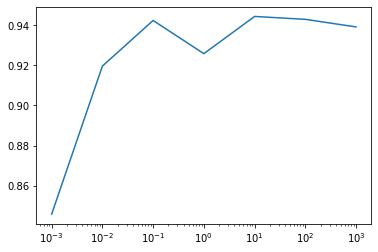

In [189]:
plt.semilogx(
    np.array([list(d.values()) for d in cv_results['params']]).flatten(), 
    cv_results['mean_test_score']
)
plt.show()

In [199]:
pipeline.set_params(svc__estimator__C=10)
pipeline.fit(train_soaps, train_cantons, **fit_params)
test_dfs = pipeline.decision_function(test_soaps)
print(balanced_accuracy_score(
    test_cantons,
    pipeline.predict(test_soaps)
))

svc_estimator = pipeline.named_steps['svc'].estimators_[0]
norm_scaler = pipeline.named_steps['norm_scaler']

support_idxs = svc_estimator.support_
support_vectors = norm_scaler.transform(train_soaps)[support_idxs]
weights = svc_estimator.dual_coef_ @ support_vectors
intercept = svc_estimator.intercept_

0.9032826086956522


# Real-space

In [200]:
reshape_args = dict(n_pairs=n_species, n_max=soap_hyperparameters['max_radial'])

test_species_soaps = reshape_soaps(
    norm_scaler.transform(test_soaps), **reshape_args
)

species_weights = reshape_soaps(
    weights, **reshape_args
)

In [201]:
print(test_dfs)
print(np.dot(norm_scaler.transform(test_soaps), weights.T).T + intercept)
print(np.sum(species_weights * test_species_soaps, axis=(-1, -2)) + intercept)

[-1.45299554 -5.51110353 -4.47749001 ...  4.83632258  2.47595371
  4.36038547]
[[-1.45299554 -5.51110353 -4.47749001 ...  4.83632258  2.47595371
   4.36038547]]
[-1.45299554 -5.51110353 -4.47749001 ...  4.83632258  2.47595371
  4.36038547]


In [202]:
r_grid = {}
dr = {}
n_pts = 10000
r_grid['DVR'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] + 3 * soap_hyperparameters['gaussian_sigma_constant'], n_pts
)
r_grid['GTO'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] * 2, n_pts
)
dr['GTO'] = np.diff(r_grid[soap_hyperparameters['radial_basis']])[0]
dr['DVR'] = 2 / n_pts

if contracted_basis:
    n_max = basis_hyperparameters['max_radial']
    projection_matrix = U[:, 0, :, 0:soap_hyperparameters['max_radial']]
else:
    n_max = soap_hyperparameters['max_radial']
    projection_matrix = None

density_args = dict(
    cutoff=soap_hyperparameters['interaction_cutoff'],
    n_max=n_max,
    r_grid=r_grid[soap_hyperparameters['radial_basis']],
    chunk_size_r=10,
    radial_basis=soap_hyperparameters['radial_basis'],
    gaussian_sigma=soap_hyperparameters['gaussian_sigma_constant'],
    projection_matrix=projection_matrix
)

soap_density = compute_soap_density(
    test_species_soaps,
    **density_args
)

weight_density = compute_soap_density(
    species_weights,
    **density_args
)

In [203]:
print(dr[soap_hyperparameters['radial_basis']] * np.sum(soap_density * weight_density, axis=(-1, -2)) + intercept)

[-1.45275108 -5.51045388 -4.47694523 ...  4.83593364  2.47580204
  4.36004456]


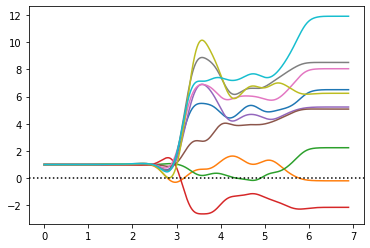

In [204]:
idxs = np.arange(0, soap_density.shape[0])
np.random.shuffle(idxs)
for i in idxs[0:10]:
    plt.plot(
        r_grid[soap_hyperparameters['radial_basis']], 
        dr[soap_hyperparameters['radial_basis']] * np.cumsum(np.sum(soap_density[i] * weight_density[0], axis=0)) + intercept
    )

plt.axhline(0, color='k', linestyle=':')
plt.show()

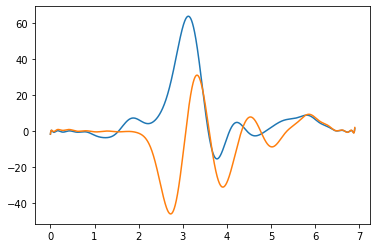

In [205]:
for n in range(0, n_species):
    plt.plot(r_grid[soap_hyperparameters['radial_basis']], weight_density[0, n])
plt.show()

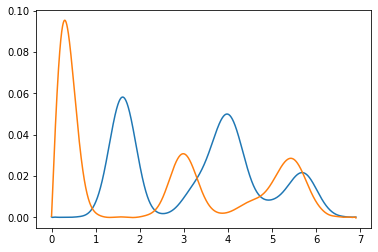

In [206]:
abs_soap_density = compute_soap_density(
    reshape_soaps(test_soaps, **reshape_args),
    **density_args
)

for n in range(0, n_species):
    plt.plot(r_grid[soap_hyperparameters['radial_basis']], abs_soap_density[0, n])
plt.show()

In [207]:
dvrs = legendre_dvr(
    basis_hyperparameters['interaction_cutoff'],
    basis_hyperparameters['max_radial'],
    basis_hyperparameters['gaussian_sigma_constant'],
    r_grid[basis_hyperparameters['radial_basis']]
)

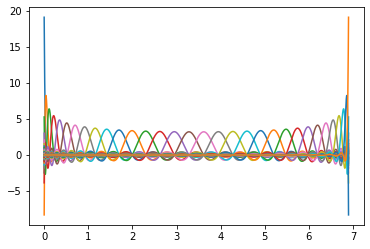

In [208]:
for dvr in dvrs:
    plt.plot(
        r_grid[basis_hyperparameters['radial_basis']],
        dvr
    )
plt.show()

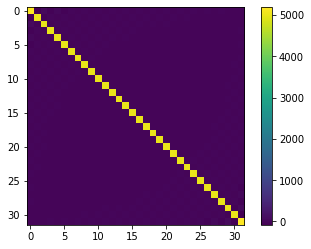

In [28]:
plt.imshow(dvrs @ dvrs.T)
plt.colorbar()
plt.show()

In [29]:
for idx1, dvr1 in enumerate(dvrs):
    for idx2, dvr2 in enumerate(dvrs):
        print(idx1, idx2, dvr1 @ dvr2 * dr['DVR'])

0 0 1.0367933987293392
0 1 -0.0161979937915454
0 2 0.010310072065655724
0 3 -0.007531199646618885
0 4 0.005908930360916187
0 5 -0.004841825112658405
0 6 0.0040836487272411645
0 7 -0.0035149469270703082
0 8 0.0030707678733128503
0 9 -0.0027127609576482977
0 10 0.002416820834431134
0 11 -0.002167031948448358
0 12 0.0019524593632080074
0 13 -0.0017653385616434112
0 14 0.0016000009573387552
0 15 -0.0014522084153299173
0 16 0.0013187259892174822
0 17 -0.0011970390104408864
0 18 0.0010851607036667095
0 19 -0.0009814983189766868
0 20 0.0008847581518042582
0 21 -0.0007938771197700984
0 22 0.0007079730519884683
0 23 -0.0006263087857862385
0 24 0.0005482673717346854
0 25 -0.0004733379218366663
0 26 0.0004011152206081339
0 27 -0.00033132491406679326
0 28 0.000263914144518474
0 29 -0.00019936502580824707
0 30 0.00014009444506286702
0 31 -0.00010230001906851754
1 0 -0.0161979937915454
1 1 1.0070112720669193
1 2 -0.004526568651004409
1 3 0.003306813954073516
1 4 -0.0025948203574108165
1 5 0.00212654